In [474]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.special import expit
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [475]:
mat = scipy.io.loadmat('ejemplo_regresion.mat')
x = mat.get('x')
y = mat.get('y')
t = mat.get('t')
consumo_mat = scipy.io.loadmat('consumoDB.mat')
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')

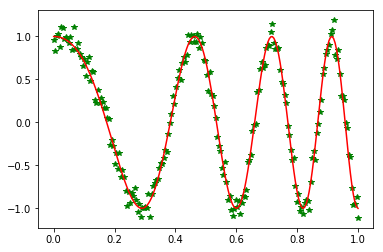

In [3]:
plt.figure
plt.plot(x, t, '*g')
plt.plot(x, y, '-r')

In [414]:
def expFunction(x, miu, s):
    return np.exp(-np.power((x - miu), 2)/(2*s*s))

def BFunction(xi, M, Fbase, x_mean):
    phiXn = np.zeros(M)
    idP = np.linspace(0, M - 1, M)
    if(Fbase == 'poly'):
        phiXn = np.power(xi, idP)
    if(Fbase == 'exp'):
        idP = np.linspace(0, 1, M)
        s = 0.05
        phiXn = expFunction(xi, idP, s)
    if(Fbase == 'sigmod'):
        s = 10
        a = (xi - idP) / s
        phiXn = expit(a)
    return phiXn


def MBFunction(x_vect, M, Fbase):
    N = np.size(x_vect)
    PHIX = np.zeros([N,M])
    for i in range(0,N):
        PHIX[i,:] = BFunction(x_vect[i],M,Fbase, np.mean(x_vect))
    return PHIX

def calcWml(mPHIXT, t):
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX))
    return mPHIXT_pw2_inv.dot(mPHIXT).dot(t)

def calcWmlReg(mPHIX, t):
    L = np.exp(-30)
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX) + L*np.eye(M))
    return mPHIXT_pw2_inv.dot(mPHIXT.dot(t))

def calcYEst(mPHIX, t):
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT).dot(t)
    return mPHIX.dot(w_ml)

def calcYEstReg(mPHIX, t):
    L = np.exp(-30)
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX) + L*np.eye(M))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT.dot(t))
    return mPHIX.dot(w_ml)


fNames = ['poly', 'sigmod', 'exp']

In [507]:
iters = 500
M = 25
mPHIX = MBFunction(x, M, 'poly')
mPHIXT = mPHIX.T
alpha = np.random.rand()
beta = np.random.rand()
invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
Sn = np.linalg.inv(invSn)
mn = beta * (Sn @ mPHIXT @ t)

yEst = mPHIX.dot(mn)
error = np.zeros(iters)
error[0] = np.squeeze(0.5 * ((t - yEst).T)@(t - yEst))
print("MSE = ", error[0])

MSE =  40.59474129208243


In [508]:
# Calculamos autovalores de PHIT*PHI
rho = np.linalg.eigvals(mPHIXT@mPHIX)
Lambda = beta * rho
Gamma = np.sum(Lambda / (alpha + Lambda))
def half_ln(N, X):
  return 0.5 * N * np.log(X)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

#def bayesian():
    #iniciamos el proceso iterativo
    #para la busqueda de alpha y beta
logEv = np.zeros(iters)
error = np.zeros(iters)

for it in range(1, iters):
  alpha = Gamma / ((mn.T)@mn)
  norm_t_phi = t - mPHIX@mn
  invBeta = 1./(N - Gamma) * ((norm_t_phi.T)@(norm_t_phi))
  beta = 1./invBeta
  #Se actualizan los parametros del posterior
  invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
  Sn = np.linalg.inv(invSn)
  mn = beta * (Sn @ mPHIXT @ t)
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  #Se calcula el error
  yEst = mPHIX.dot(mn)
  error[it] = np.squeeze((0.5 * ((t - yEst).T)@(t - yEst)))
  logEv[it] = logEvi(invSn, alpha, beta, 2 * error[it])

TypeError: can't convert complex to float

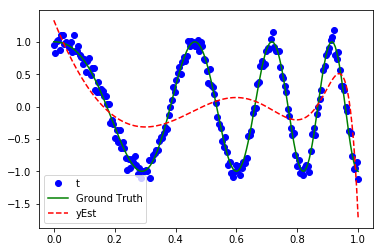

In [506]:
plt.plot(x,t,'ob')

plt.plot(x,y,'-g')
plt.plot(x,yEst,'--r')
plt.legend(('t','Ground Truth','yEst'))

In [439]:
M=30
N = x.shape[0]
mPHIX = MBFunction(x, M, 'poly')
w_ml = calcWml(mPHIX, t)
yEst = mPHIX.dot(w_ml)

w_mlReg = calcWmlReg(mPHIX, t)
yEstReg = mPHIX.dot(w_mlReg)

aux = t - mPHIX.dot(w_ml)
beta_ml = (1. / N) * aux.T.dot(aux)
print(beta_ml)

[[0.00834557]]


MSE =  0.001339895030235661
MSE reg =  0.0014783020400198875


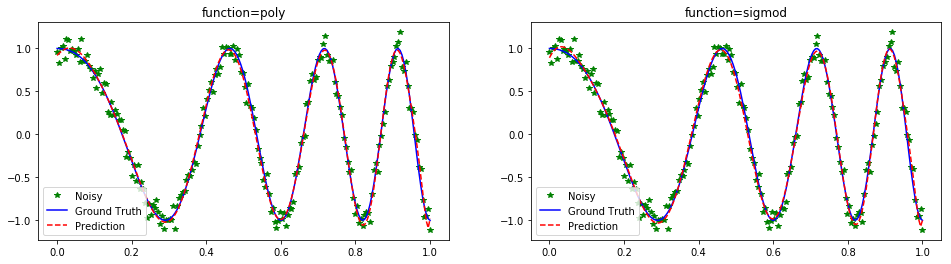

In [444]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

import pylab as pb
for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  #upper = pred + 2 * np.sqrt(beta_ml)
  #lower = pred - 2 * np.sqrt(beta_ml)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  #pb.plot(x,upper,color="#204a87",linewidth=0.2)
  #pb.plot(x,lower,color="#204a87",linewidth=0.2)
  #pb.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color="#729fcf",alpha=0.3)

  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

In [431]:
M=22
N = x.shape[0]
mPHIX = MBFunction(x, M, 'sigmod')
yEst = calcYEst(mPHIX, t)
yEstReg = calcYEstReg(mPHIX, t)

MSE =  0.47197681425894517
MSE reg =  0.4719768050647107


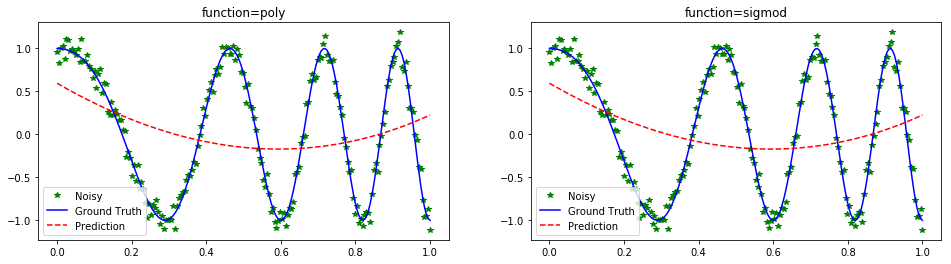

In [399]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

In [411]:
M=20
N = x.shape[0]
mPHIX = MBFunction(x, M, 'exp')
yEst = calcYEst(mPHIX, t)
yEstReg = calcYEstReg(mPHIX, t)

MSE =  0.0008660695801719129
MSE reg =  0.0008660695801718049


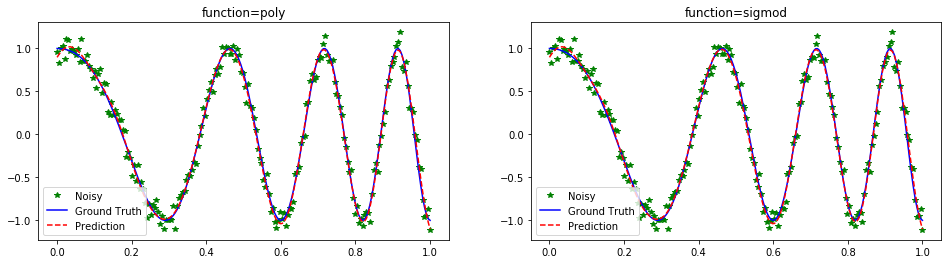

In [412]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


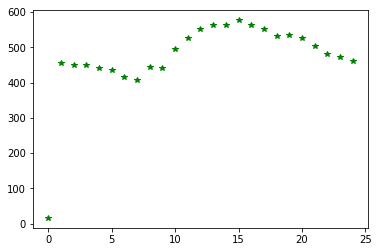

In [4]:
consumo_x = consumo_mat.get('x')
consumo_t = consumo_mat.get('t')
std_consumo_x = preprocessing.scale(consumo_x)
std_consumo_t = preprocessing.scale(consumo_t)
plt.figure
plt.plot(consumo_x, consumo_t, '*g')

In [149]:
M=26
N = consumo_x.shape[0]
std_consumo_x = preprocessing.scale(consumo_x)
std_consumo_t = preprocessing.scale(consumo_t)
mPHIX = MBFunction(std_consumo_x, M, 'poly')
yEst = calcYEst(mPHIX, std_consumo_t)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


MSE =  0.002535025875531407


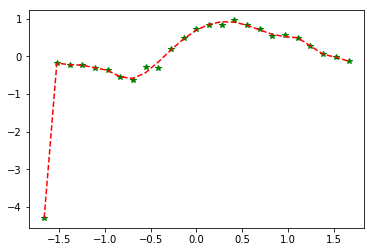

In [284]:
plt.plot(std_consumo_x, std_consumo_t, '*g')
plt.plot(std_consumo_x, yEst, '--r')
diff = std_consumo_t - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [285]:
M=19
mPHIX = MBFunction(consumo_x, M, 'sigmod')
yEst = calcYEst(mPHIX, consumo_t)

MSE =  181.68923796474738


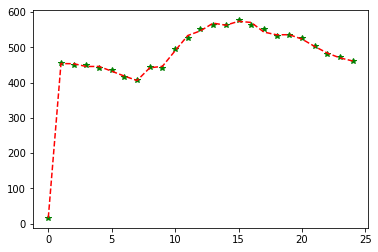

In [286]:
plt.plot(consumo_x, consumo_t, '*g')
plt.plot(consumo_x, yEst, '--r')

diff = consumo_t - yEst
error = 0.5 * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [384]:
M=20
mPHIX = MBFunction(consumo_x, M, 'exp')
yEst = calcYEst(mPHIX, consumo_t)

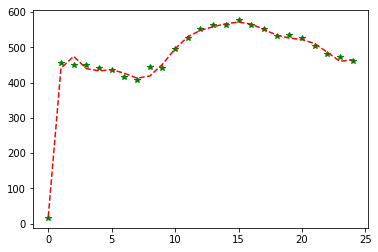

In [385]:
plt.plot(consumo_x, consumo_t, '*g')
plt.plot(consumo_x, yEst, '--r')

(50, 1)

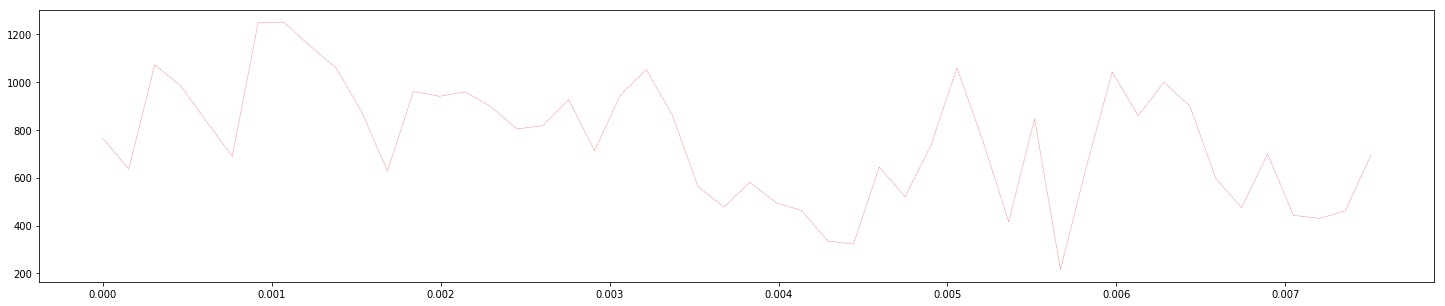

In [618]:
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')
hr_t = hrsignal_mat.get('HR')[:50]
hr_x = hrsignal_mat.get('x').T[:50]

std_x = preprocessing.scale(hr_x)
std_t = preprocessing.scale(hr_t)

plt.figure(figsize=(25,5))
plt.plot(hr_x, hr_t,  linestyle='--' , linewidth=0.3, color='red')
hr_t.shape

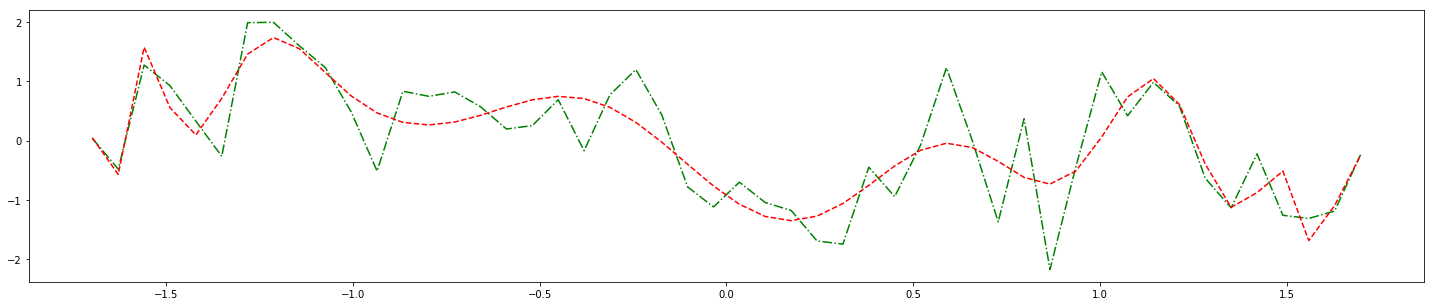

In [626]:
M=25
mPHIX = MBFunction(std_x, M, 'poly')
yEst = calcYEst(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x,std_t, '-.g')
plt.plot(std_x, yEst, '--r')

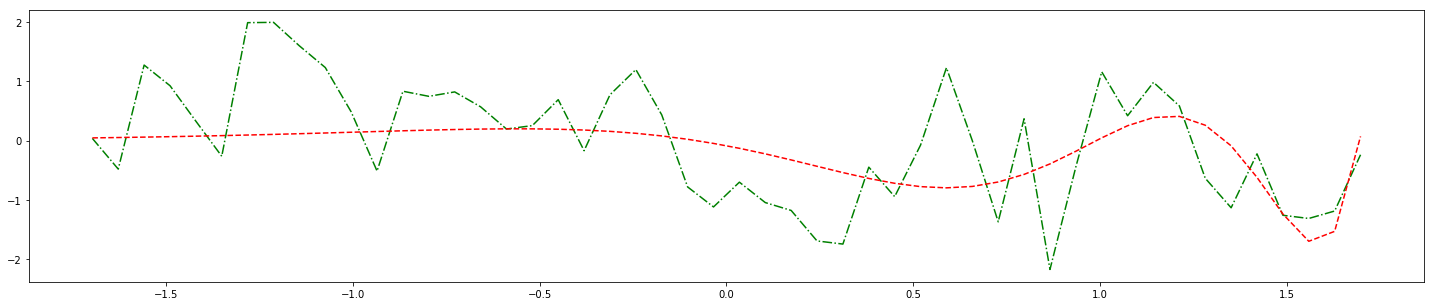

In [636]:
M=40
mPHIX = MBFunction(std_x, M, 'sigmod')
yEst = calcYEst(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x,std_t, '-.g')
plt.plot(std_x, yEst, '--r')

In [245]:
a = [1]
b = [2]
c = [3]
print()
for idx, y_est in enumerate([a, b,c ]):
    print(idx, y_est)


0 [1]
1 [2]
2 [3]
